In [4]:
from qaravan.core import two_local_circ, RunContext
from qaravan.applications import brickwall_skeleton
from qaravan.tensorQ import StatevectorSim, random_sv
import torch
from plotting import *

In [5]:
# Define the problem 
n = 4
target_sv = torch.tensor(random_sv(n))

def infidelity(params, skeleton, target_sv): 
    circ = two_local_circ(skeleton, params)
    sim = StatevectorSim(circ, backend="torch")
    sim.run(progress_bar=False)
    ansatz_sv = sim.get_statevector()
    return 1 - torch.abs(torch.dot(ansatz_sv.conj(), target_sv))**2

In [6]:
# set up ansatz and optimizer
num_layers = 2
skeleton = brickwall_skeleton(n, num_layers)
params = torch.nn.Parameter(torch.randn(15*len(skeleton)))
optimizer = torch.optim.Adam([params], lr=0.05)


# set up RunContext for logging, checkpointing, and stopping
context = RunContext(
    progress_interval=10,
    max_iter=10000,
    checkpoint_file="checkpoint.pickle",
    checkpoint_interval=100,
    resume=False,
    convergence_check=True,
    stop_ratio=1e-8, 
    stop_absolute=1e-7
)

# initialize the state of the run
cost_list = []
run_state = {
    "cost_list": cost_list,
    "step": context.step
}

while True: 
    cost = infidelity(params, skeleton, target_sv)
    cost_list.append(cost.item())
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Update run state
    run_state["step"] += 1
    run_state["cost_list"] = cost_list

    # Let RunContext handle logging, checkpointing, and stopping
    if context.step_update(run_state):
        print(f"Terminating at step {run_state['step']} with cost {cost_list[-1]}")
        break

Step 10 at 2025-08-18T19:09:49 with cost 0.21659592840217168
Step 20 at 2025-08-18T19:09:50 with cost 0.047900431570805146
Step 30 at 2025-08-18T19:09:51 with cost 0.027240702380846527
Step 40 at 2025-08-18T19:09:52 with cost 0.010414854263895879
Step 50 at 2025-08-18T19:09:52 with cost 0.0035814806063567683
Step 60 at 2025-08-18T19:09:53 with cost 0.0014258518830081446
Step 70 at 2025-08-18T19:09:54 with cost 0.0004971702851351845
Step 80 at 2025-08-18T19:09:54 with cost 0.00013015984988795637
Step 90 at 2025-08-18T19:09:55 with cost 7.140077913558862e-05
Step 100 at 2025-08-18T19:09:56 with cost 1.78100439705009e-05
[Checkpoint saved at step 100 in file checkpoint.pickle]
Step 110 at 2025-08-18T19:09:56 with cost 6.055704336094259e-06
Step 120 at 2025-08-18T19:09:57 with cost 2.712719154085441e-06
Step 130 at 2025-08-18T19:09:58 with cost 9.528423920990292e-07
Absolute stop condition met with cost 4.142677756391322e-08 at step 135
Terminating at step 135 with cost 4.142677756391322e-

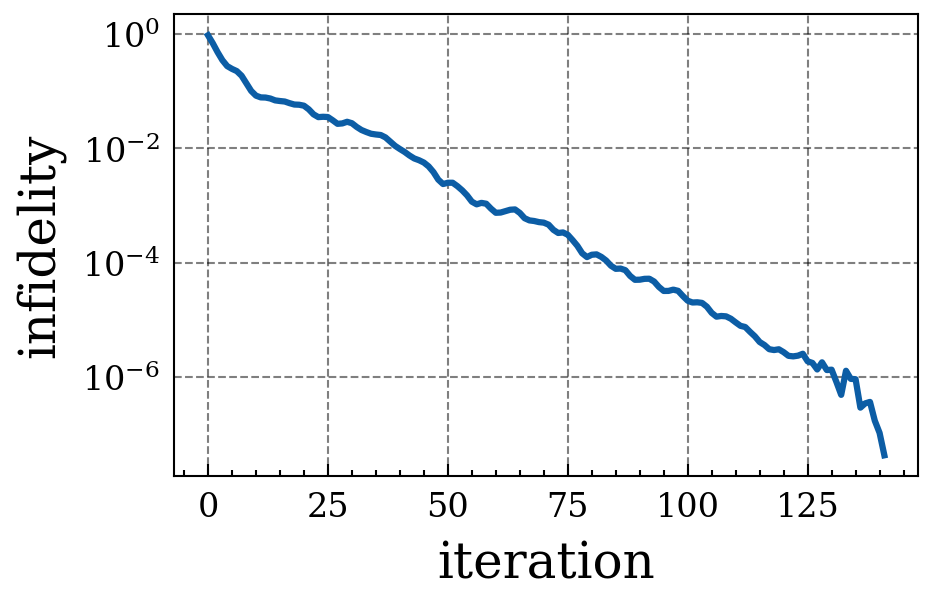

In [4]:
set_style()
fig, ax = plt.subplots(figsize=(3.2,2))
ax.plot(cost_list, lw=1.5, color="C0")
ax.set_xlabel("iteration", fontsize=12)
ax.set_ylabel("infidelity", fontsize=12)
ax.set_yscale("log")